In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install mne
from tensorflow.keras.layers import CategoryEncoding
from keras.layers import Lambda, Input, Dense, LeakyReLU, Flatten, Reshape, GlobalAveragePooling2D, BatchNormalization
from keras.layers.convolutional import Conv2D,Conv2DTranspose, MaxPooling2D
from keras.layers.core import Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, mean_squared_error
from keras.utils.vis_utils import plot_model
from keras import backend as K
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

import sklearn.multioutput as MOR
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import welch
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from mne.decoding import Vectorizer

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import argparse
import os
import h5py
import scipy.io as sio
# tf.compat.v1.disable_eager_execution()
tf.compat.v1.enable_eager_execution()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 4.8 MB/s 


In [ ]:
batch_size = 2
channel_dim = 32
latent_dim=15
epoch_dim=40
epochs = 50
subNum = 32
zscore = True
sample_dim=8064

In [ ]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
# importing data
X_data=np.zeros([32,40,40,8064])
y_data=np.zeros([32,40,3])
for participant in range(32):
  if participant<9:
    sub_data_file = sio.loadmat('/content/drive/My Drive/Dissertation/DEAP/data_preprocessed_matlab/s'+'0'+str(participant+1)+'.mat')
  else:
    sub_data_file = sio.loadmat('/content/drive/My Drive/Dissertation/DEAP/data_preprocessed_matlab/s'+str(participant+1)+'.mat')
  x_train=sub_data_file['data']
  y_data[participant]=sub_data_file['labels'][:,:3]
  
  # data normalization
  mu=np.mean(x_train,axis=0)
  std=np.std(x_train,axis=0,ddof=1)
  for epoch in range(40):
    x_train[epoch]=(x_train[epoch]-mu)/std
  X_data[participant]=x_train
print(X_data.shape)

(32, 40, 40, 8064)


In [ ]:
# reshaping
X_data_reshaped=np.zeros([32,40,8064,32,1])
for participant in range(X_data.shape[0]):
  x_train=tf.expand_dims(X_data[participant],3)

  x_train=x_train[:,:channel_dim,:,:]

  lst=[]
  for epoch in range(40):
    lst.append(tf.transpose(x_train[epoch,:,:,0]))
  x_train=tf.stack(lst)

  x_train=tf.expand_dims(x_train,3)
  X_data_reshaped[participant]=x_train
x_test=X_data_reshaped

print(X_data_reshaped.shape)

(32, 40, 8064, 32, 1)


In [ ]:
X_pred=np.zeros([32,40,100])                      
for participant in range(32):
  # Encoder
  inputs=Input(shape=(sample_dim,channel_dim,1),name='encoder_input')
  h=Conv2D(filters=30,kernel_size=(8,2),strides=(8,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs)
  h=BatchNormalization(axis=-1)(h)
  h=Conv2D(filters=30,kernel_size=(8,2),strides=(8,2),padding='valid',activation=LeakyReLU(alpha=0.3))(h)
  h=BatchNormalization(axis=-1)(h)
  h=Conv2D(filters=30,kernel_size=(6,2),strides=(6,2),padding='valid',activation=LeakyReLU(alpha=0.3))(h)
  h=BatchNormalization(axis=-1)(h)
  h=Dropout(0.5)(h)
  h=Flatten()(h)
  h = Dense(252,activation=LeakyReLU(alpha=0.3))(h)
  z_mean = Dense(100, name='z_mean')(h)
  z_log_var = Dense(100, name='z_log_var')(h)
  z = Lambda(sampling, output_shape=(100,), name='z')([z_mean, z_log_var])
  encoder= Model(inputs, [z_mean, z_log_var, z], name='encoder')
  # encoder.summary()
  # plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

  # Decoder
  latent_inputs = Input(shape=(100,), name='z_sampling')
  h_decoded = Dense(252,activation=LeakyReLU(alpha=0.3))(latent_inputs)
  inputs_decoded = Dense(2520, activation=LeakyReLU(alpha=0.3))(h_decoded)
  inputs_decoded=Reshape((21,4,30))(inputs_decoded)
  inputs_decoded=Conv2DTranspose(30,kernel_size=(6,2),strides=(6,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs_decoded)
  inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
  inputs_decoded=Dropout(0.5)(inputs_decoded)
  inputs_decoded=Conv2DTranspose(30,kernel_size=(8,2),strides=(8,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs_decoded)
  inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
  inputs_decoded=Conv2DTranspose(1,kernel_size=(8,2),strides=(8,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs_decoded)
  inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
  inputs_decoded=Reshape((sample_dim,channel_dim,1))(inputs_decoded)
  decoder = Model(latent_inputs, inputs_decoded, name='decoder')
  # decoder.summary()
  # plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

  #VAE
  outputs = decoder(encoder.output[2])
  vae = Model(inputs, outputs, name='vae_mlp')
  vae.summary()
  # plot_model(vae,to_file='vae_mlp.png', show_shapes=True)

  # Loss function
  reconstruction_loss=K.square(inputs)-K.square(outputs)
  reconstruction_loss = K.mean(reconstruction_loss, axis=None)
  reconstruction_loss *= channel_dim

  kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)

  vae.add_loss(vae_loss)
  rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
  vae.compile(optimizer=rmsprop)


  callback=ModelCheckpoint(filepath='/content/drive/My Drive/Dissertation/DEAP/checkpoints/',
                            save_weights_only=True,
                            save_best_only=True)


  # train the autoencoder
  history=vae.fit(X_data_reshaped[participant],
                  epochs=epochs,
                  steps_per_epoch=40//batch_size,
                  batch_size=batch_size,
                  validation_data=(x_test[participant],None),
                  validation_steps=40//batch_size)

  # save the model
  vae.save_weights('/content/drive/My Drive/Dissertation/DEAP/checkpoints/vae_deap_'+str(participant+1)+'.h5',overwrite=True,save_format='h5')
  encoder.save_weights('/content/drive/My Drive/Dissertation/DEAP/checkpoints/encoder_deap_'+str(participant+1)+'.h5',overwrite=True,save_format='h5')

  X_pred[participant]=encoder.predict(X_data_reshaped[participant])[2]

  vae.load_weights('/content/drive/My Drive/Dissertation/DEAP/checkpoints/vae_deap_1.h5')

  plt.clf()

  fig = go.Figure()
  fig.add_trace(go.Scattergl(
                      y=history.history['loss'],
                      name='Train'))
  fig.add_trace(go.Scattergl(
                      y=history.history['val_loss'],
                      name='Valid'))
  fig.update_layout(height=500, 
                    width=700,
                    title='Loss function',
                    xaxis_title='Epoch',
                    yaxis_title='Loss')
  fig.show()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 1008, 16, 30  120        ['conv2d_3[0][0]']               
 rmalization)                   )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_12 (BatchN  (None, 1008, 16, 30  120        ['conv2d_6[0][0]']               
 ormalization)                  )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



20/20 [==============================] - 2s 30ms/step - loss: 319.1360 - val_loss: 32.1292
Epoch 2/50
20/20 [==============================] - 0s 14ms/step - loss: 246.7237 - val_loss: 32.4716
Epoch 3/50
20/20 [==============================] - 0s 12ms/step - loss: 219.7199 - val_loss: 32.9903
Epoch 4/50
20/20 [==============================] - 0s 16ms/step - loss: 206.0182 - val_loss: 33.6165
Epoch 5/50
20/20 [==============================] - 0s 17ms/step - loss: 185.9355 - val_loss: 34.2470
Epoch 6/50
20/20 [==============================] - 0s 24ms/step - loss: 161.1315 - val_loss: 34.8369
Epoch 7/50
20/20 [==============================] - 0s 16ms/step - loss: 151.2129 - val_loss: 35.4190
Epoch 8/50
20/20 [==============================] - 0s 13ms/step - loss: 151.4040 - val_loss: 35.7070
Epoch 9/50
20/20 [==============================] - 0s 23ms/step - loss: 132.5195 - val_loss: 36.1083
Epoch 10/50
20/20 [==============================] - 0s 15ms/step - loss: 123.4617 - val_loss

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 1008, 16, 30  120        ['conv2d_9[0][0]']               
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_24 (BatchN  (None, 1008, 16, 30  120        ['conv2d_12[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_30 (BatchN  (None, 1008, 16, 30  120        ['conv2d_15[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 1008, 16, 30  120        ['conv2d_18[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_42 (BatchN  (None, 1008, 16, 30  120        ['conv2d_21[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_48 (BatchN  (None, 1008, 16, 30  120        ['conv2d_24[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 1008, 16, 30  120        ['conv2d_27[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_60 (BatchN  (None, 1008, 16, 30  120        ['conv2d_30[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_66 (BatchN  (None, 1008, 16, 30  120        ['conv2d_33[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 1008, 16, 30  120        ['conv2d_36[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_78 (BatchN  (None, 1008, 16, 30  120        ['conv2d_39[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 1008, 16, 30  120        ['conv2d_42[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_90 (BatchN  (None, 1008, 16, 30  120        ['conv2d_45[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_96 (BatchN  (None, 1008, 16, 30  120        ['conv2d_48[0][0]']              
 ormalization)                  )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_51 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_102 (Batch  (None, 1008, 16, 30  120        ['conv2d_51[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_108 (Batch  (None, 1008, 16, 30  120        ['conv2d_54[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_114 (Batch  (None, 1008, 16, 30  120        ['conv2d_57[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_120 (Batch  (None, 1008, 16, 30  120        ['conv2d_60[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_63 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_126 (Batch  (None, 1008, 16, 30  120        ['conv2d_63[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_66 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_132 (Batch  (None, 1008, 16, 30  120        ['conv2d_66[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 1008, 16, 30  120        ['conv2d_69[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_72 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_144 (Batch  (None, 1008, 16, 30  120        ['conv2d_72[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_75 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_150 (Batch  (None, 1008, 16, 30  120        ['conv2d_75[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_78 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_156 (Batch  (None, 1008, 16, 30  120        ['conv2d_78[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_162 (Batch  (None, 1008, 16, 30  120        ['conv2d_81[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_84 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_168 (Batch  (None, 1008, 16, 30  120        ['conv2d_84[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_87 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_174 (Batch  (None, 1008, 16, 30  120        ['conv2d_87[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_90 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_180 (Batch  (None, 1008, 16, 30  120        ['conv2d_90[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_93 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_186 (Batch  (None, 1008, 16, 30  120        ['conv2d_93[0][0]']              
 Normalization)                 )                                                           

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_192 (Batch  (None, 1008, 16, 30  120        ['conv2d_96[0][0]']              
 Normalization)                 )                                                           

<Figure size 432x288 with 0 Axes>

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 8064, 32, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 1008, 16, 30  510         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 1008, 16, 30  120        ['conv2d_3[0][0]']               
 rmalization)                   )                                                           

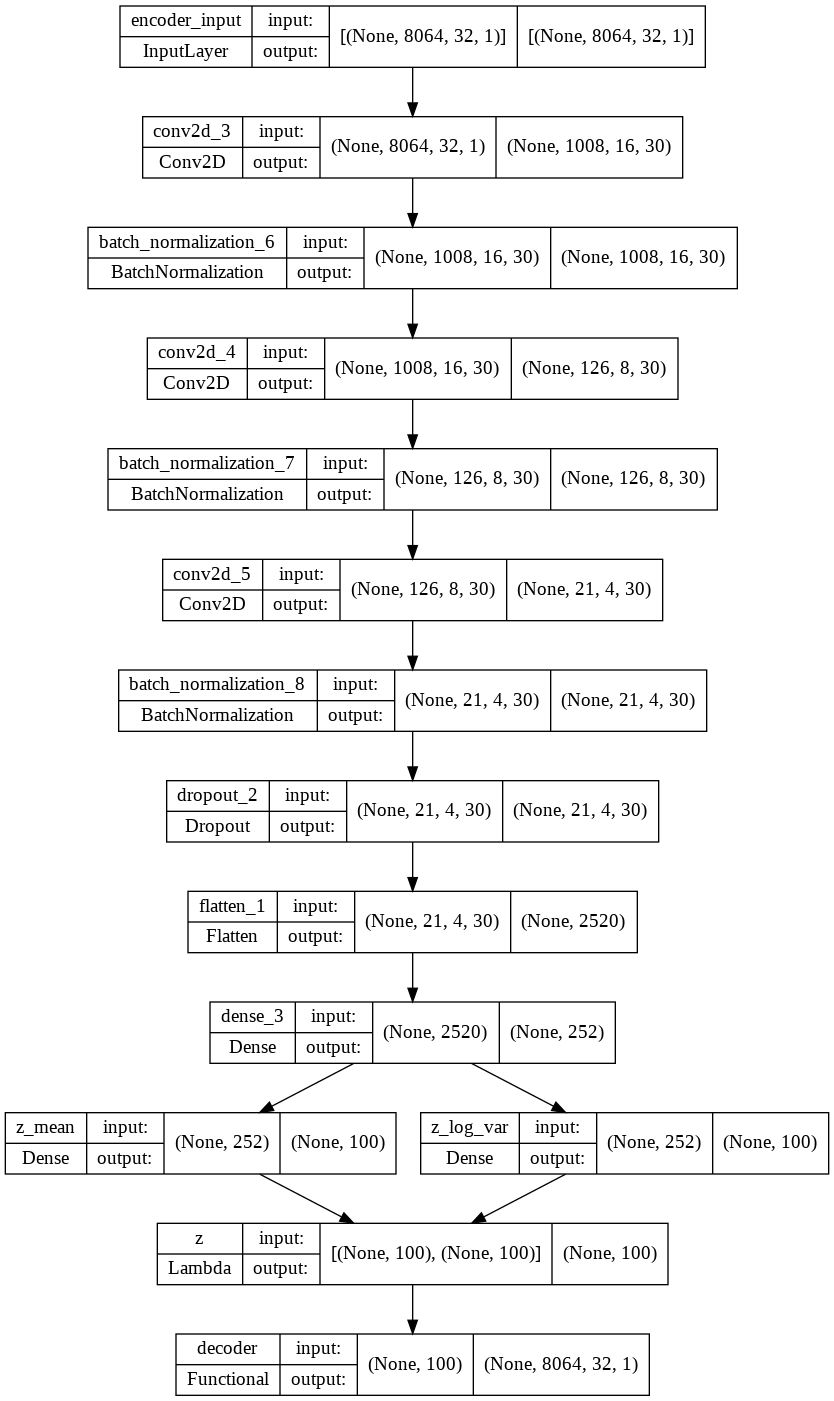

In [ ]:
# VAE ARCHITECTURE VISUALISATION
# Encoder
inputs=Input(shape=(sample_dim,channel_dim,1),name='encoder_input')
h=Conv2D(filters=30,kernel_size=(8,2),strides=(8,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs)
h=BatchNormalization(axis=-1)(h)
h=Conv2D(filters=30,kernel_size=(8,2),strides=(8,2),padding='valid',activation=LeakyReLU(alpha=0.3))(h)
h=BatchNormalization(axis=-1)(h)
h=Conv2D(filters=30,kernel_size=(6,2),strides=(6,2),padding='valid',activation=LeakyReLU(alpha=0.3))(h)
h=BatchNormalization(axis=-1)(h)
h=Dropout(0.5)(h)
h=Flatten()(h)
h = Dense(252,activation=LeakyReLU(alpha=0.3))(h)
z_mean = Dense(100, name='z_mean')(h)
z_log_var = Dense(100, name='z_log_var')(h)
z = Lambda(sampling, output_shape=(100,), name='z')([z_mean, z_log_var])
encoder= Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()
# plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# Decoder
latent_inputs = Input(shape=(100,), name='z_sampling')
h_decoded = Dense(252,activation=LeakyReLU(alpha=0.3))(latent_inputs)
inputs_decoded = Dense(2520, activation=LeakyReLU(alpha=0.3))(h_decoded)
inputs_decoded=Reshape((21,4,30))(inputs_decoded)
inputs_decoded=Conv2DTranspose(30,kernel_size=(6,2),strides=(6,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs_decoded)
inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
inputs_decoded=Dropout(0.5)(inputs_decoded)
inputs_decoded=Conv2DTranspose(30,kernel_size=(8,2),strides=(8,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs_decoded)
inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
inputs_decoded=Conv2DTranspose(1,kernel_size=(8,2),strides=(8,2),padding='valid',activation=LeakyReLU(alpha=0.3))(inputs_decoded)
inputs_decoded=BatchNormalization(axis=-1)(inputs_decoded)
inputs_decoded=Reshape((sample_dim,channel_dim,1))(inputs_decoded)
decoder = Model(latent_inputs, inputs_decoded, name='decoder')
# decoder.summary()
# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

#VAE
outputs = decoder(encoder.output[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()
plot_model(vae,to_file='vae_mlp.png', show_shapes=True)


In [ ]:
# SPLITTING OF DATA
# POWER SPECTRAL DENSITY

# save decoded signals in csv format
import pandas as pd

psd_svr=np.zeros([32,40,51])

rmse_svm=[]
mae_svm=[]
for participant in range(32):
  # dec=X_pred[participant]
  # df=pd.DataFrame(dec)
  # df.to_csv('/content/drive/My Drive/Dissertation/DEAP/data_decoded/participant'+str(participant)+'.csv')
  dec=pd.read_csv('/content/drive/My Drive/Dissertation/DEAP/data_decoded/participant'+str(participant)+'.csv').to_numpy()
  psd_svr[participant]=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]

  # REGRESSION 
  # With SVR
  svr=svm.SVR(kernel='rbf',C=1.0,epsilon=0.2)
  clf=MOR.MultiOutputRegressor(svr)
  y_pred=cross_val_predict(clf,psd_svr[participant],y_data[participant],cv=5)


  # METRICS FOR SVR
  MSE=mean_squared_error(y_data[participant],y_pred)
  MAE=mean_absolute_error(y_data[participant],y_pred)
  R2=r2_score(y_data[participant],y_pred)
  print('RMSE for participant {} = {}'.format(participant,np.sqrt(MSE)))
  print('MAE for participant {} = {}'.format(participant,MAE))
  print('R2 for participant {} = {}'.format(participant,R2))
  print('')
  rmse_svm.append(MSE)
  mae_svm.append(MAE)

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

RMSE for participant 0 = 2.8038680877900926
MAE for participant 0 = 2.4214263404915806
R2 for participant 0 = -0.5135315129189083

RMSE for participant 1 = 3.0998521544869027
MAE for participant 1 = 2.6280479184118923
R2 for participant 1 = -0.1586154788401093

RMSE for participant 2 = 1.526861814880475
MAE for participant 2 = 1.263896760900124
R2 for participant 2 = -0.2736741917345247

RMSE for participant 3 = 2.2382280476088123
MAE for participant 3 = 1.9262900430468477
R2 for participant 3 = -0.2134757725468428

RMSE for participant 4 = 2.4658687796487433
MAE for participant 4 = 2.083293588395687
R2 for participant 4 = -0.2341864049051713

RMSE for participant 5 = 1.7443378975588604
MAE for participant 5 = 1.4810052529703537
R2 for participant 5 = -0.21582499404866762

RMSE for participant 6 = 2.271469635906833
MAE for participant 6 = 1.9034568473172973
R2 for participant 6 = -0.24270107467641475

RMSE for participant 7 = 1.9038098086182778
MAE for participant 7 = 1.548590217024096

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

RMSE for participant 12 = 2.5852083240325565
MAE for participant 12 = 2.156826549224535
R2 for participant 12 = -0.26519416752443986

RMSE for participant 13 = 2.3677828561868566
MAE for participant 13 = 2.0251090022260385
R2 for participant 13 = -0.3695441397485799

RMSE for participant 14 = 2.3293911880656784
MAE for participant 14 = 1.9694179921380413
R2 for participant 14 = -0.2938470730158813

RMSE for participant 15 = 1.9730440316359767
MAE for participant 15 = 1.627759419805036
R2 for participant 15 = -0.03353670546643339

RMSE for participant 16 = 1.3043561504641266
MAE for participant 16 = 1.0442297709937287
R2 for participant 16 = -0.2527469213532863

RMSE for participant 17 = 1.2383402833289001
MAE for participant 17 = 1.0190318803460243
R2 for participant 17 = -0.1322096274844277



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

RMSE for participant 18 = 1.8767801643432458
MAE for participant 18 = 1.56656010602779
R2 for participant 18 = -0.24566448722300746

RMSE for participant 19 = 1.5525651289981726
MAE for participant 19 = 1.2576513212865101
R2 for participant 19 = -0.11083595087461684

RMSE for participant 20 = 1.8380254866060297
MAE for participant 20 = 1.4769381053377177
R2 for participant 20 = -0.02833091900468006

RMSE for participant 21 = 2.141639125452712
MAE for participant 21 = 1.7060436250565028
R2 for participant 21 = -0.12839443439559473

RMSE for participant 22 = 2.1233925464616883
MAE for participant 22 = 1.7739607937085597
R2 for participant 22 = -0.12042427130743068

RMSE for participant 23 = 1.996802140085329
MAE for participant 23 = 1.6804241280497667
R2 for participant 23 = -0.2350467684022121



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

RMSE for participant 24 = 2.237704214521326
MAE for participant 24 = 1.763320747367189
R2 for participant 24 = -0.16985736293823472

RMSE for participant 25 = 2.4302314275188106
MAE for participant 25 = 2.003362343941709
R2 for participant 25 = -0.20474325700972354

RMSE for participant 26 = 2.0905321676442745
MAE for participant 26 = 1.5238192011527998
R2 for participant 26 = -0.129167148344233

RMSE for participant 27 = 2.9163576714594712
MAE for participant 27 = 2.534780756875604
R2 for participant 27 = -0.37534534963133953

RMSE for participant 28 = 2.812561404816083
MAE for participant 28 = 2.446195320604543
R2 for participant 28 = -0.3094737850963225

RMSE for participant 29 = 1.4414599112830992
MAE for participant 29 = 1.1374959211742364
R2 for participant 29 = -0.11656394638848666

RMSE for participant 30 = 2.772711789109471
MAE for participant 30 = 2.3215114515056423
R2 for participant 30 = -0.3131177394263851

RMSE for participant 31 = 1.7772480254849385
MAE for participant 3

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


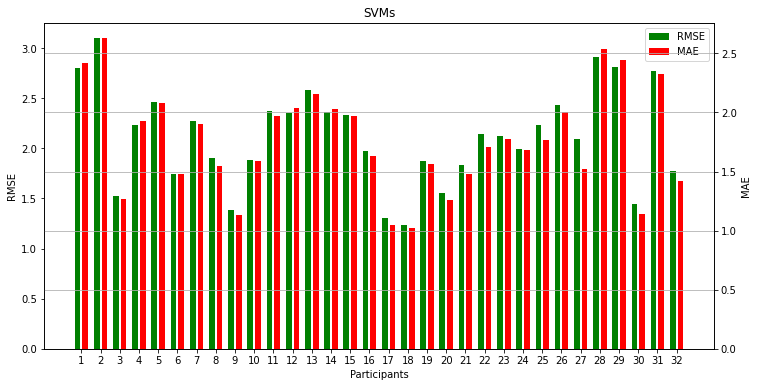

In [ ]:
# Plot results in bar charts
parts=np.arange(1,33)
lst=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_svm),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_svm,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('SVMs')
plt.grid(True)
plt.show()

In [ ]:
# SPLITTING OF DATA
# POWER SPECTRAL DENSITY
rmse_knn=[]
mae_knn=[]

psd_knn=np.zeros([32,40,51])
for participant in range(32):
  df=pd.read_csv('/content/drive/My Drive/Dissertation/DEAP/data_decoded/participant'+str(participant)+'.csv')
  dec=df.to_numpy()
  psd_knn[participant]=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]

  # REGRESSION 
  # With k-NNs
  knn=KNeighborsRegressor(n_neighbors=23)
  regr_knn=MOR.MultiOutputRegressor(knn)
  y_pred_knn=cross_val_predict(regr_knn,psd_svr[participant],y_data[participant],cv=5)


  # METRICS FOR k-NN
  MSE_knn=mean_squared_error(y_data[participant],y_pred_knn)
  MAE_knn=mean_absolute_error(y_data[participant],y_pred_knn)
  R2_knn=r2_score(y_data[participant],y_pred_knn)
  print('RMSE for participant {} = {}'.format(participant,np.sqrt(MSE_knn)))
  print('MAE for participant {} = {}'.format(participant,MAE_knn))
  print('R2 for participant {} = {}'.format(participant,R2_knn))
  print('')
  rmse_knn.append(MSE_knn)
  mae_knn.append(MAE_knn)

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

RMSE for participant 0 = 2.495497376593442
MAE for participant 0 = 2.312626811594203
R2 for participant 0 = -0.2329097646748651

RMSE for participant 1 = 3.0371909843306377
MAE for participant 1 = 2.6321702898550727
R2 for participant 1 = -0.11180263521039757

RMSE for participant 2 = 1.4901570020216757
MAE for participant 2 = 1.2486920289855072
R2 for participant 2 = -0.20002336667005216

RMSE for participant 3 = 2.079441709434616
MAE for participant 3 = 1.8098623188405798
R2 for participant 3 = -0.0547629325806965

RMSE for participant 4 = 2.4119145439848864
MAE for participant 4 = 2.039594202898551
R2 for participant 4 = -0.18381630238835153

RMSE for participant 5 = 1.6780554949617705
MAE for participant 5 = 1.475865942028986
R2 for participant 5 = -0.13073050392905997

RMSE for participant 6 = 2.2172224790092834
MAE for participant 6 = 1.9360253623188413
R2 for participant 6 = -0.18773569413398436

RMSE for participant 7 = 1.85288453316922
MAE for participant 7 = 1.502384057971014

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

RMSE for participant 11 = 2.1896859451613837
MAE for participant 11 = 1.910032608695652
R2 for participant 11 = -0.1777563331527491

RMSE for participant 12 = 2.539467586994137
MAE for participant 12 = 2.1253442028985505
R2 for participant 12 = -0.2324380718202906

RMSE for participant 13 = 2.1653515240596204
MAE for participant 13 = 1.9271992753623186
R2 for participant 13 = -0.1909402035233628

RMSE for participant 14 = 2.198387748084099
MAE for participant 14 = 1.8551847826086956
R2 for participant 14 = -0.18877088921484

RMSE for participant 15 = 1.9614397850165441
MAE for participant 15 = 1.6279782608695654
R2 for participant 15 = -0.025405032972916148

RMSE for participant 16 = 1.2547554093790947
MAE for participant 16 = 1.012855072463768
R2 for participant 16 = -0.17579220848044466



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

RMSE for participant 17 = 1.2664632418815702
MAE for participant 17 = 1.0405289855072464
R2 for participant 17 = -0.1800445052516552

RMSE for participant 18 = 1.8466193591685198
MAE for participant 18 = 1.579605072463768
R2 for participant 18 = -0.21583424459738207

RMSE for participant 19 = 1.585552508759652
MAE for participant 19 = 1.2715797101449275
R2 for participant 19 = -0.12345333895508774

RMSE for participant 20 = 1.8998193012604419
MAE for participant 20 = 1.5830000000000002
R2 for participant 20 = -0.09473438543532109

RMSE for participant 21 = 2.0820471199074264
MAE for participant 21 = 1.6822282608695651
R2 for participant 21 = -0.09725286993932321

RMSE for participant 22 = 2.1363306634340735
MAE for participant 22 = 1.853061594202898
R2 for participant 22 = -0.16143044787126648



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

RMSE for participant 23 = 2.000449604473406
MAE for participant 23 = 1.6626521739130435
R2 for participant 23 = -0.227759737787841

RMSE for participant 24 = 2.204952826246751
MAE for participant 24 = 1.7364927536231882
R2 for participant 24 = -0.11399055564469192

RMSE for participant 25 = 2.454783688079563
MAE for participant 25 = 2.0416014492753622
R2 for participant 25 = -0.2566205373929444

RMSE for participant 26 = 2.1316037842002054
MAE for participant 26 = 1.5819818840579714
R2 for participant 26 = -0.18694902553200055

RMSE for participant 27 = 2.664958090797843
MAE for participant 27 = 2.396985507246377
R2 for participant 27 = -0.1537273198581334

RMSE for participant 28 = 2.630543958687733
MAE for participant 28 = 2.317079710144928
R2 for participant 28 = -0.15046280099291934



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

RMSE for participant 29 = 1.4088673858685505
MAE for participant 29 = 1.1179963768115941
R2 for participant 29 = -0.06565594536633412

RMSE for participant 30 = 2.630366147745125
MAE for participant 30 = 2.2103333333333333
R2 for participant 30 = -0.19899763868583534

RMSE for participant 31 = 1.787389981015448
MAE for participant 31 = 1.4931847826086955
R2 for participant 31 = -0.15548398147299838



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


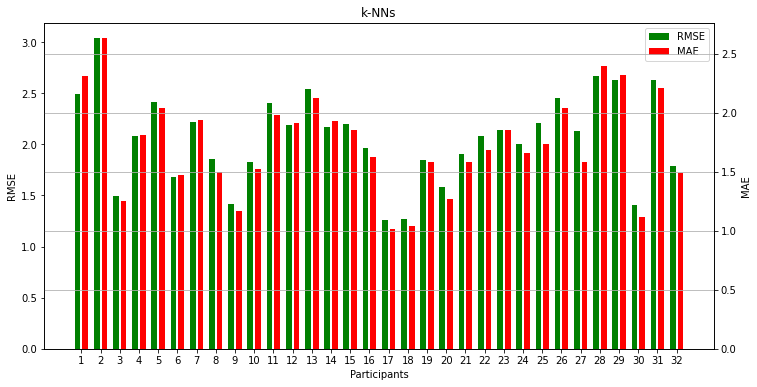

In [ ]:
# Plot results in bar charts
parts=np.arange(1,33)
lst=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_knn),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_knn,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('k-NNs')
plt.grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


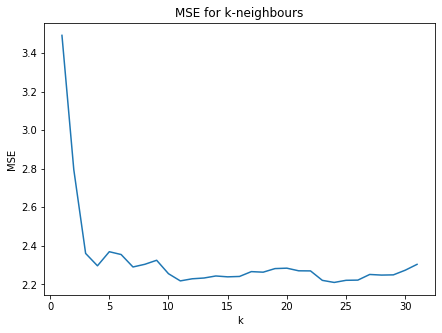


Number of k with lowest MSE equal to 23 and with MSE equal to 2.2097667230902776


In [ ]:
# HYPER-PARAMETER TUNING FOR K-NNS
# data only with a random participant
df=pd.read_csv('/content/drive/My Drive/Dissertation/DEAP/data_decoded/participant2.csv')
dec=df.to_numpy()
psd_knn=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]

mse=[]
for k in range(1,32):
  knn=KNeighborsRegressor(n_neighbors=k)
  regr_knn=MOR.MultiOutputRegressor(knn)
  y_pred_knn=cross_val_predict(regr_knn,psd_knn,y_data[2],cv=5)
  MSE_knn=mean_squared_error(y_data[2],y_pred_knn)
  mse.append(MSE_knn)

k=np.where(mse==np.min(mse))

plt.figure(figsize=(7,5))
plt.plot(range(1,32),mse)
plt.title('MSE for k-neighbours')
plt.xlabel('k')
plt.ylabel('MSE')
plt.show()
print('')
print('Number of k with lowest MSE equal to {} and with MSE equal to {}'.format(k[0][0],np.min(mse)))

In [ ]:
# SPLITTING OF DATA
# POWER SPECTRAL DENSITY
rmse_rf=[]
mae_rf=[]

psd_rf=np.zeros([32,40,51])
for participant in range(32):
  df=pd.read_csv('/content/drive/My Drive/Dissertation/DEAP/data_decoded/participant'+str(participant)+'.csv')
  dec=df.to_numpy()
  psd_rf[participant]=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]

  # REGRESSION 
  # With RFs
  rf=RandomForestRegressor(n_estimators=58, criterion='absolute_error', max_depth=8)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,psd_rf[participant],y_data[participant],cv=5)

  # METRICS FOR RF
  MSE_rf=mean_squared_error(y_data[participant],y_pred_rf)
  MAE_rf=mean_absolute_error(y_data[participant],y_pred_rf)
  R2_rf=r2_score(y_data[participant],y_pred_rf)
  print('RMSE for participant {} = {}'.format(participant,np.sqrt(MSE_rf)))
  print('MAE for participant {} = {}'.format(participant,MAE_rf))
  print('R2 for participant {} = {}'.format(participant,R2_rf))
  print('')
  rmse_rf.append(MSE_rf)
  mae_rf.append(MAE_rf)

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 0 = 2.566157442091302
MAE for participant 0 = 2.2705251436781606
R2 for participant 0 = -0.27864413696052825



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 1 = 3.0137783917098315
MAE for participant 1 = 2.5736781609195405
R2 for participant 1 = -0.09330550185803359



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 2 = 1.493889137557943
MAE for participant 2 = 1.2338297413793105
R2 for participant 2 = -0.213866314471999



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 3 = 2.1871272181654975
MAE for participant 3 = 1.8730373563218394
R2 for participant 3 = -0.16339600560698223



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 4 = 2.4468495085191626
MAE for participant 4 = 2.0651824712643676
R2 for participant 4 = -0.2235969454247809



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 5 = 1.7789675410128505
MAE for participant 5 = 1.524510775862069
R2 for participant 5 = -0.26005359874517486



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 6 = 2.2000667533978286
MAE for participant 6 = 1.868376436781609
R2 for participant 6 = -0.15968877821400107



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 7 = 1.8910637862512012
MAE for participant 7 = 1.5428599137931034
R2 for participant 7 = -0.19396186634857013



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 8 = 1.372696290661614
MAE for participant 8 = 1.1433936781609197
R2 for participant 8 = -0.0925439206153084



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 9 = 1.692124801729887
MAE for participant 9 = 1.4127499999999997
R2 for participant 9 = -1.3137704744684934e-05



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 10 = 2.386920864438027
MAE for participant 10 = 1.9889525862068969
R2 for participant 10 = -0.17782641181354167



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 11 = 2.271636048744017
MAE for participant 11 = 1.9683556034482759
R2 for participant 11 = -0.24334528868629265



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 12 = 2.726543480438804
MAE for participant 12 = 2.2986623563218385
R2 for participant 12 = -0.4179736568347474



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 13 = 2.1490330368326673
MAE for participant 13 = 1.857530890804598
R2 for participant 13 = -0.19406866407978263



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 14 = 1.370028875235986
MAE for participant 14 = 1.0557083333333335
R2 for participant 14 = 0.37935635755772606



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 15 = 1.9940599344791237
MAE for participant 15 = 1.6024238505747128
R2 for participant 15 = -0.03532357567842592



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 16 = 1.2314964891763782
MAE for participant 16 = 0.9632313218390801
R2 for participant 16 = -0.12216686172445253



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 17 = 1.2143692703904807
MAE for participant 17 = 0.9878886494252872
R2 for participant 17 = -0.11377338625245996



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 18 = 1.9365977679831687
MAE for participant 18 = 1.6206594827586207
R2 for participant 18 = -0.3292359304317301



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 19 = 1.590006338625511
MAE for participant 19 = 1.2787564655172416
R2 for participant 19 = -0.18681335710206523



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 20 = 1.9160930942741246
MAE for participant 20 = 1.5738081896551728
R2 for participant 20 = -0.12348215490661014



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 21 = 1.966503709225901
MAE for participant 21 = 1.6574058908045979
R2 for participant 21 = -0.035790754899096035



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 22 = 2.028928119277176
MAE for participant 22 = 1.6980129310344827
R2 for participant 22 = -0.05447654355948665



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 23 = 1.8375029836533865
MAE for participant 23 = 1.4729073275862072
R2 for participant 23 = -0.06834511800388132



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 24 = 2.154892631537754
MAE for participant 24 = 1.7295869252873561
R2 for participant 24 = -0.09235741711002676



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 25 = 2.2340966096121626
MAE for participant 25 = 1.8597147988505747
R2 for participant 25 = -0.004977298412347213



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 26 = 2.162671779319942
MAE for participant 26 = 1.5391803160919537
R2 for participant 26 = -0.2182820383433249



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 27 = 2.554544373574694
MAE for participant 27 = 2.1851214080459767
R2 for participant 27 = -0.057862879991887516



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 28 = 2.751364948940025
MAE for participant 28 = 2.442092672413793
R2 for participant 28 = -0.2511708632443012



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 29 = 1.443032986364974
MAE for participant 29 = 1.155176724137931
R2 for participant 29 = -0.12115654326907548



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 30 = 2.6086289466137718
MAE for participant 30 = 2.1293900862068966
R2 for participant 30 = -0.14398855914259512



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


RMSE for participant 31 = 1.7596507849874687
MAE for participant 31 = 1.447403735632184
R2 for participant 31 = -0.14761441246518361



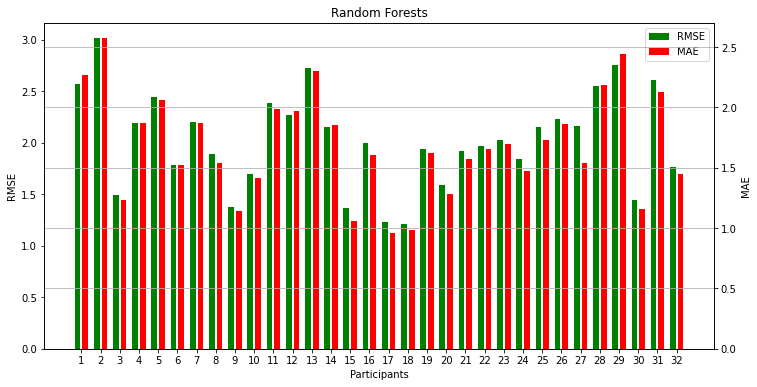

In [ ]:
# Plot results in bar charts
parts=np.arange(1,33)
lst=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_rf),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_rf,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('Random Forests')
plt.grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


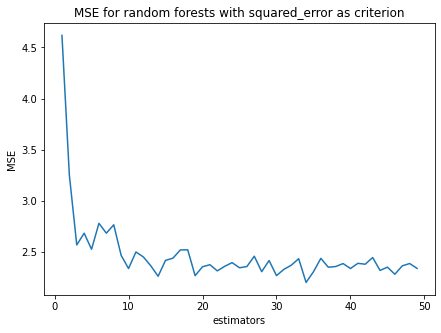


Number of estimators with lowest MSE equal to 33 and with MSE equal to 2.204239434832757


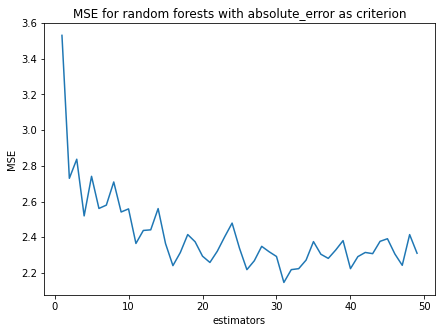


Number of estimators with lowest MSE equal to 30 and with MSE equal to 2.1465093739160594


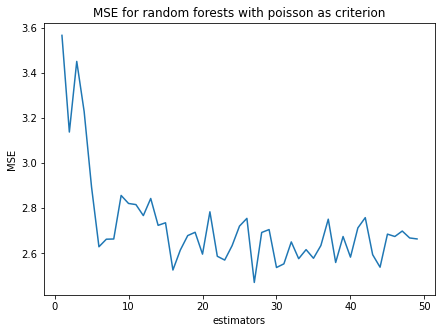


Number of estimators with lowest MSE equal to 26 and with MSE equal to 2.470777430269776


In [ ]:
# HYPER-PARAMETER TUNING FOR RANDOM FORESTS
df=pd.read_csv('/content/drive/My Drive/Dissertation/DEAP/data_decoded/participant2.csv')
dec=df.to_numpy()
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]

criteria=['squared_error','absolute_error', 'poisson']

for criterion in criteria:
  mse=[]
  for estimator in range(1,50):
    rf=RandomForestRegressor(n_estimators=estimator, criterion=criterion, max_depth=None)
    regr_rf=MOR.MultiOutputRegressor(rf)
    y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_data[2],cv=5)
    MSE_rf=mean_squared_error(y_data[2],y_pred_rf)
    mse.append(MSE_rf)

  _k=np.where(mse==np.min(mse))

  plt.figure(figsize=(7,5))
  plt.plot(range(1,50),mse)
  plt.title('MSE for random forests with {} as criterion'.format(criterion))
  plt.xlabel('estimators')
  plt.ylabel('MSE')
  plt.show()
  print('')
  print('Number of estimators with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


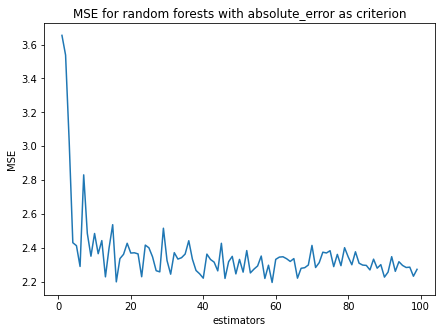


Number of estimators with lowest MSE equal to 58 and with MSE equal to 2.1956893342430344


In [ ]:
# TUNING FOR NUMBER OF ESTIMATORS
df=pd.read_csv('/content/drive/My Drive/Dissertation/DEAP/data_decoded/participant2.csv')
dec=df.to_numpy()
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
X_train, X_test, y_train, y_test = train_test_split(psd_rf, y_data[2], test_size=0.2, random_state=42)

mse=[]
for estimator in range(1,100):
  rf=RandomForestRegressor(n_estimators=estimator, criterion='absolute_error', max_depth=None)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_data[2],cv=5)
  MSE_rf=mean_squared_error(y_data[2],y_pred_rf)
  mse.append(MSE_rf)

_k=np.where(mse==np.min(mse))

plt.figure(figsize=(7,5))
plt.plot(range(1,100),mse)
plt.title('MSE for random forests with {} as criterion'.format('absolute_error'))
plt.xlabel('estimators')
plt.ylabel('MSE')
plt.show()
print('')
print('Number of estimators with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))


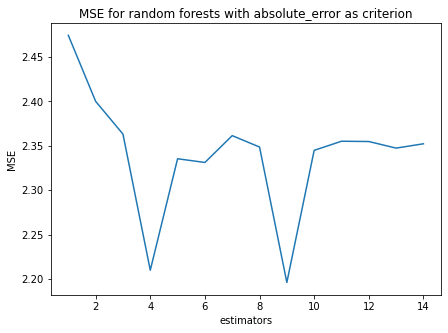


Maximum depth with lowest MSE equal to 8 and with MSE equal to 2.196068327697682


In [ ]:
# TUNING FOR MAX-DEPTH
df=pd.read_csv('/content/drive/My Drive/Dissertation/DEAP/data_decoded/participant2.csv')
dec=df.to_numpy()
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
X_train, X_test, y_train, y_test = train_test_split(psd_rf, y_data[2], test_size=0.2, random_state=42)

mse=[]
for depth in range(1,15):
  rf=RandomForestRegressor(n_estimators=58, criterion='absolute_error', max_depth=depth)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_data[2],cv=5)
  MSE_rf=mean_squared_error(y_data[2],y_pred_rf)
  mse.append(MSE_rf)

_k=np.where(mse==np.min(mse))

plt.figure(figsize=(7,5))
plt.plot(range(1,15),mse)
plt.title('MSE for random forests with {} as criterion'.format('absolute_error'))
plt.xlabel('estimators')
plt.ylabel('MSE')
plt.show()
print('')
print('Maximum depth with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))